# Binary classification for revenue optimization problem

### XGBoost Classifier

In [94]:
# Import necessary packages
# pip install xgboost 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb  # pip install xgboost
from pandas import DataFrame
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier

### Load data

In [4]:
demo=pd.read_excel('D:/Courses and Projects/Revenue optimization/Task_Data_Scientist_Dataset.xlsx',sheet_name=1)
demo.describe()
demo.shape

(1615, 4)

In [5]:
prod_balance=pd.read_excel('D:/Courses and Projects/Revenue optimization/Task_Data_Scientist_Dataset.xlsx',sheet_name=2)
prod_balance.describe()
prod_balance.shape

(1615, 13)

In [6]:
inflow_outflow=pd.read_excel('D:/Courses and Projects/Revenue optimization/Task_Data_Scientist_Dataset.xlsx',sheet_name=3)
inflow_outflow.describe()
inflow_outflow.shape

(1587, 15)

In [7]:
sales_revenue=pd.read_excel('D:/Courses and Projects/Revenue optimization/Task_Data_Scientist_Dataset.xlsx',sheet_name=4)
sales_revenue.describe()
sales_revenue.shape

(969, 7)

### Check for missing data

In [8]:
print('Columns with null values in Demo data:',demo.isnull().sum(), sep = '\n')

Columns with null values in Demo data:
Client    0
Sex       3
Age       0
Tenure    0
dtype: int64


In [9]:
print('Columns with null values in AccBalance data:',prod_balance.isnull().sum(), sep = '\n')

Columns with null values in AccBalance data:
Client           0
Count_CA         0
Count_SA      1189
Count_MF      1309
Count_OVD     1196
Count_CC      1445
Count_CL      1480
ActBal_CA        0
ActBal_SA     1189
ActBal_MF     1309
ActBal_OVD    1196
ActBal_CC     1445
ActBal_CL     1480
dtype: int64


In [10]:
print('Columns with null values in AccBalance data:',prod_balance.isnull().sum(), sep = '\n')

Columns with null values in AccBalance data:
Client           0
Count_CA         0
Count_SA      1189
Count_MF      1309
Count_OVD     1196
Count_CC      1445
Count_CL      1480
ActBal_CA        0
ActBal_SA     1189
ActBal_MF     1309
ActBal_OVD    1196
ActBal_CC     1445
ActBal_CL     1480
dtype: int64


In [11]:
print('Columns with null values in Flow data:',inflow_outflow.isnull().sum(), sep = '\n')

Columns with null values in Flow data:
Client                          0
VolumeCred                      0
VolumeCred_CA                   0
TransactionsCred                0
TransactionsCred_CA             0
VolumeDeb                       0
VolumeDeb_CA                    0
VolumeDebCash_Card              0
VolumeDebCashless_Card          0
VolumeDeb_PaymentOrder          0
TransactionsDeb                 0
TransactionsDeb_CA              0
TransactionsDebCash_Card        0
TransactionsDebCashless_Card    0
TransactionsDeb_PaymentOrder    0
dtype: int64


In [12]:
print('Columns with null values in Sales data:',sales_revenue.isnull().sum(), sep = '\n')

Columns with null values in Sales data:
Client        0
Sale_MF       0
Sale_CC       0
Sale_CL       0
Revenue_MF    0
Revenue_CC    0
Revenue_CL    0
dtype: int64


### Replace missing values

In [13]:
cols=['Count_SA','Count_MF','Count_OVD','Count_CC','Count_CL','ActBal_SA','ActBal_MF','ActBal_OVD','ActBal_CC','ActBal_CL']
prod_balance[cols]=prod_balance[cols].fillna(0)
print('Columns with null values in AccBalance data:',prod_balance.isnull().sum(), sep = '\n')

Columns with null values in AccBalance data:
Client        0
Count_CA      0
Count_SA      0
Count_MF      0
Count_OVD     0
Count_CC      0
Count_CL      0
ActBal_CA     0
ActBal_SA     0
ActBal_MF     0
ActBal_OVD    0
ActBal_CC     0
ActBal_CL     0
dtype: int64


In [14]:
prod_balance.loc[:,'Count_CL'].describe()

count    1615.000000
mean        0.099071
std         0.360837
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: Count_CL, dtype: float64

In [15]:
prod_balance[prod_balance['Client']==829]

,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
828,829,1,0.0,0.0,0.0,1.0,5.0,183.661429,0.0,0.0,0.0,2.344643,1506.501429


In [16]:
demo['Sex'].fillna('Other',inplace=True)
print('Columns with null values in Demo data:',demo.isnull().sum(), sep = '\n')

Columns with null values in Demo data:
Client    0
Sex       0
Age       0
Tenure    0
dtype: int64


### Data manipulation: Process data based on assumptions

#### Encode categorical variables

In [17]:
demo = pd.get_dummies(demo, columns = ['Sex'])
demo.head()

,Client,Age,Tenure,Sex_F,Sex_M,Sex_Other
0,1,51,7,1,0,0
1,2,43,152,0,1,0
2,3,17,140,0,1,0
3,4,24,153,0,1,0
4,5,58,200,1,0,0


##### Create new field 'Tenure_years' based on the given data Tenure (in months)

In [18]:
demo['Tenure_years']=demo['Tenure']/12
demo.head()

,Client,Age,Tenure,Sex_F,Sex_M,Sex_Other,Tenure_years
0,1,51,7,1,0,0,0.583333
1,2,43,152,0,1,0,12.666667
2,3,17,140,0,1,0,11.666667
3,4,24,153,0,1,0,12.750000
4,5,58,200,1,0,0,16.666667


Delete records where client's age is less than tenure in years

In [20]:
demo_filtered=demo[demo['Age']>=demo['Tenure_years']]
demo_filtered.shape

(1568, 7)

### Data integration

In [21]:
demo_balance=demo_filtered.merge(prod_balance,on="Client")
demo_balance.shape

(1568, 19)

In [22]:
demo_balance.head()

,Client,Age,Tenure,Sex_F,Sex_M,Sex_Other,Tenure_years,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,1,51,7,1,0,0,0.583333,1,0.0,0.0,1.0,0.0,0.0,1333.802857,0.000000,0.000000,0.0,0.000000,0.0
1,2,43,152,0,1,0,12.666667,1,1.0,0.0,0.0,0.0,0.0,110.768571,13326.190357,0.000000,0.0,0.000000,0.0
2,3,17,140,0,1,0,11.666667,1,0.0,1.0,0.0,0.0,0.0,482.654643,0.000000,107.251786,0.0,0.000000,0.0
3,4,24,153,0,1,0,12.750000,1,1.0,0.0,0.0,1.0,0.0,1599.840714,76.437143,0.000000,0.0,1110.381786,0.0
4,5,58,200,1,0,0,16.666667,1,1.0,0.0,0.0,0.0,0.0,5353.483929,8079.715714,0.000000,0.0,0.000000,0.0


In [25]:
demo_balance_inflow=demo_balance.merge(inflow_outflow,on="Client")
demo_balance_inflow.shape

(1540, 33)

##### Delete all records where a minor client (age less than 18) holds either a credit card or consumer loan. Note that minor clients can have mutual funds in their name, with the guidance of an adult family member. 

In [164]:
# delete all records where a client with age < 18 has either a credit card or consumer loan. 
# Note: Minor clients can only have mutual funds in their name
index=demo_balance_inflow[(demo_balance_inflow['Age']<18) & ((demo_balance_inflow['Count_CL'] > 0)| (demo_balance_inflow['Count_CC'] > 0))].index
demo_balance_inflow.drop(index,inplace=True)
demo_balance_inflow.shape

(1531, 33)

In [165]:
demo_balance_inflow.loc[:,'Count_CL'].describe()

count    1531.000000
mean        0.099282
std         0.364171
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: Count_CL, dtype: float64

In [31]:
demo_balance_inflow[demo_balance_inflow['Client']==829]

,Client,Age,Tenure,Sex_F,Sex_M,Sex_Other,Tenure_years,Count_CA,Count_SA,Count_MF,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
795,829,80,71,1,0,0,5.916667,1,0.0,0.0,...,1339.893571,1328.072143,178.571429,196.732857,597.142857,34,31,4,9,14


In [32]:
# randomly check if filtering is in place
demo_balance_inflow[(demo_balance_inflow['Age']<18) & (demo_balance_inflow['Count_CC'] > 0)]

,Client,Age,Tenure,Sex_F,Sex_M,Sex_Other,Tenure_years,Count_CA,Count_SA,Count_MF,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder


In [33]:
data=demo_balance_inflow.merge(sales_revenue,on="Client")
data.shape

(911, 39)

In [34]:
data.head()

,Client,Age,Tenure,Sex_F,Sex_M,Sex_Other,Tenure_years,Count_CA,Count_SA,Count_MF,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1,51,7,1,0,0,0.583333,1,0.0,0.0,...,30,3,12,9,1,0,0,26.972679,0.0,0.0
1,2,43,152,0,1,0,12.666667,1,1.0,0.0,...,6,2,2,1,0,0,0,0.000000,0.0,0.0
2,6,24,19,1,0,0,1.583333,1,0.0,0.0,...,6,1,0,0,0,0,0,0.000000,0.0,0.0
3,8,64,30,1,0,0,2.500000,1,0.0,0.0,...,24,10,1,0,0,0,0,0.000000,0.0,0.0
4,13,66,132,1,0,0,11.000000,1,1.0,0.0,...,39,6,17,10,0,0,0,0.000000,0.0,0.0


In [35]:
data.loc[:,'Count_CL'].describe()

count    911.000000
mean       0.090011
std        0.319029
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: Count_CL, dtype: float64

In [36]:
# Random filter check on final merged data
data[(data['Age']<18) & (data['Count_CL']>0)]
raw_data=data.copy()

In [37]:
print('Columns with null values in the data:',raw_data.isnull().sum(), sep = '\n')

Columns with null values in the data:
Client                          0
Age                             0
Tenure                          0
Sex_F                           0
Sex_M                           0
Sex_Other                       0
Tenure_years                    0
Count_CA                        0
Count_SA                        0
Count_MF                        0
Count_OVD                       0
Count_CC                        0
Count_CL                        0
ActBal_CA                       0
ActBal_SA                       0
ActBal_MF                       0
ActBal_OVD                      0
ActBal_CC                       0
ActBal_CL                       0
VolumeCred                      0
VolumeCred_CA                   0
TransactionsCred                0
TransactionsCred_CA             0
VolumeDeb                       0
VolumeDeb_CA                    0
VolumeDebCash_Card              0
VolumeDebCashless_Card          0
VolumeDeb_PaymentOrder          0
Transactio

### Normalizing the features 

Normalize all features to the range [0,1], except Client_ID. This is done to optimize the training process of the machine learning model. 

In [39]:
# Perform min-max normalization
scaler = MinMaxScaler()
data.iloc[:,1:33] = scaler.fit_transform(data.iloc[:,1:33])

# convert the array back to a dataframe
data_norm = DataFrame(data)

In [40]:
data_norm.describe()

,Client,Age,Tenure,Sex_F,Sex_M,Sex_Other,Tenure_years,Count_CA,Count_SA,Count_MF,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
count,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,...,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000
mean,810.196487,0.464661,0.364123,0.462130,0.535675,0.002195,0.364123,0.025979,0.109404,0.011922,...,0.167894,0.081537,0.090011,0.137890,0.205269,0.251372,0.290889,1.985947,2.822308,3.441812
std,463.669169,0.204704,0.239767,0.498838,0.499000,0.046829,0.239767,0.110204,0.194197,0.052758,...,0.158217,0.108857,0.140808,0.155307,0.404120,0.434040,0.454422,10.183239,18.231940,7.607763
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,420.500000,0.294118,0.147601,0.000000,0.000000,0.000000,0.147601,0.000000,0.000000,0.000000,...,0.048193,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,812.000000,0.435294,0.339483,0.000000,1.000000,0.000000,0.339483,0.000000,0.000000,0.000000,...,0.132530,0.040000,0.033333,0.088235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1213.500000,0.635294,0.557196,1.000000,1.000000,0.000000,0.557196,0.000000,0.333333,0.000000,...,0.228916,0.120000,0.116667,0.205882,0.000000,1.000000,1.000000,0.000000,0.142857,4.250000
max,1613.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,220.488214,407.962500,133.275357


In [41]:
data_norm.shape

(911, 39)

In [42]:
data_norm.head()

,Client,Age,Tenure,Sex_F,Sex_M,Sex_Other,Tenure_years,Count_CA,Count_SA,Count_MF,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1,0.541176,0.025830,1.0,0.0,0.0,0.025830,0.0,0.000000,0.0,...,0.361446,0.12,0.200000,0.264706,1,0,0,26.972679,0.0,0.0
1,2,0.447059,0.560886,0.0,1.0,0.0,0.560886,0.0,0.333333,0.0,...,0.072289,0.08,0.033333,0.029412,0,0,0,0.000000,0.0,0.0
2,6,0.223529,0.070111,1.0,0.0,0.0,0.070111,0.0,0.000000,0.0,...,0.072289,0.04,0.000000,0.000000,0,0,0,0.000000,0.0,0.0
3,8,0.694118,0.110701,1.0,0.0,0.0,0.110701,0.0,0.000000,0.0,...,0.289157,0.40,0.016667,0.000000,0,0,0,0.000000,0.0,0.0
4,13,0.717647,0.487085,1.0,0.0,0.0,0.487085,0.0,0.333333,0.0,...,0.469880,0.24,0.283333,0.294118,0,0,0,0.000000,0.0,0.0


## Model for customer propensity to buy mutual funds

In [166]:
# Using normalized data
X=data_norm.iloc[:,:33] 
y=data_norm.iloc[:,33] 
revenue_MF = data_norm.loc[:,'Revenue_MF']
X_revenue=pd.concat([X,revenue_MF],axis=1)

In [167]:
# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=0,stratify=y) 

### Training an XGBoost Classifier

In [174]:
# define the model and fit to training data
#weights={0:1.0,1:10.0}

model= XGBClassifier()
model=model.fit(X_train,y_train)

#get predictions from the model
y_pred=model.predict(X_test)
target_names=['Sales_MF']
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86       109
           1       0.33      0.14      0.20        28

    accuracy                           0.77       137
   macro avg       0.57      0.53      0.53       137
weighted avg       0.71      0.77      0.73       137



In [175]:
# Predict propensity 
pred_prob=model.predict_proba(X_test)[:,1]
pred_prob

array([1.1043145e-01, 5.0500322e-02, 1.1708642e-02, 9.2184981e-03,
       2.2056188e-01, 9.3524642e-02, 2.4281248e-02, 1.0011242e-03,
       5.9387410e-01, 3.2465283e-03, 4.0141670e-03, 9.0732956e-03,
       3.3118936e-01, 1.7773772e-02, 1.0901453e-03, 4.5623225e-03,
       9.7606190e-02, 2.3807658e-02, 1.8537858e-01, 1.8299928e-02,
       2.5630403e-02, 6.2483180e-01, 5.0584853e-01, 9.1278777e-02,
       7.1122288e-04, 5.2503001e-02, 2.5448989e-02, 2.5677672e-01,
       5.4609654e-03, 1.1307249e-02, 6.1578614e-01, 2.8842841e-03,
       8.0578126e-02, 4.9078133e-02, 5.4998990e-02, 5.9897853e-03,
       5.2610422e-03, 6.4652048e-02, 3.1606935e-02, 3.8760573e-02,
       2.0475740e-02, 8.4544839e-03, 1.4310360e-01, 2.2247641e-01,
       1.1154896e-02, 5.1877587e-03, 4.2321580e-03, 1.3864213e-01,
       1.0444416e-01, 2.2687668e-02, 3.5707446e-04, 8.1325285e-03,
       7.0566006e-02, 2.6263060e-02, 2.6708725e-03, 4.9122170e-02,
       5.5824739e-01, 1.8977247e-03, 5.7307896e-03, 4.2026781e

In [177]:
clients=X_test.loc[:,'Client']
revenue=data.query('Client in @clients')['Revenue_MF']
propensity=pred_prob
revenue_adjusted=revenue.multiply(propensity)

Propensity_MF=pd.DataFrame({"Client":clients, "Revenue":revenue,"Propensity":propensity})
Propensity_MF['Revenue adjusted'] = revenue_adjusted
Propensity_MF.sort_values("Propensity",ascending=False,inplace=True)
Propensity_MF

,Client,Revenue,Propensity,Revenue adjusted
710,1266,0.000000,0.901354,0.000000
482,864,30.697321,0.809130,24.838122
863,1535,0.000000,0.780699,0.000000
747,1322,0.000000,0.720797,0.000000
611,1079,0.000000,0.687870,0.000000
...,...,...,...,...
57,95,0.000000,0.001001,0.000000
481,863,0.000000,0.000865,0.000000
162,290,0.000000,0.000711,0.000000
346,617,0.000000,0.000357,0.000000


### Feature selection using Decision tree

The goal is to use decision tree classifier to reduce dimensions of the data (feature selection), after which the machine learning model should be able to perform the same as before, or better.

In [178]:
#define the model
model=DecisionTreeClassifier() # default split criterion: gini 
#fit the model with X,y data
model.fit(X,y)
#get feature importance
importance=model.feature_importances_
#summarize feature importance
df=pd.DataFrame({'Feature':X.columns,'Importance':importance})
df.set_index('Feature',inplace=True)
df.sort_values(by='Importance',ascending=False,inplace=True)
df

,Importance
Feature,
Client,0.128581
VolumeDebCashless_Card,0.082488
VolumeCred_CA,0.078501
ActBal_CA,0.077529
VolumeDeb_CA,0.075692
Age,0.061755
Tenure,0.047668
VolumeDeb_PaymentOrder,0.045156
VolumeDeb,0.042897


In [179]:
# Include features with importance scores > 0.01
cols_to_include=df[df['Importance']>0.01].index.tolist()

In [180]:
# Train XGBoost classifier with the reduced data
# define the model and fit to training data
#weights={0:1.0,1:10.0}

model= XGBClassifier()
model=model.fit(X_train.loc[:,cols_to_include],y_train)

#get predictions from the model
y_pred=model.predict(X_test.loc[:,cols_to_include])
target_names=['Sales_MF']
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       109
           1       0.18      0.07      0.10        28

    accuracy                           0.74       137
   macro avg       0.49      0.49      0.48       137
weighted avg       0.67      0.74      0.70       137



Comparing precision, recall and F1 scores before and after feature selection, it is evident that with reduced set of features, the model performance does not have a major impact, i.e; neither a major improvement nor a deterioration in performance can be noted.

### Handling imbalanced data 

Visualize the distribution of target variable (Sales) in class values 0 and 1. Often times, a mismatch in target data distribution hampers the learning capacity of the machine learning model.

Text(0, 0.5, 'Count')

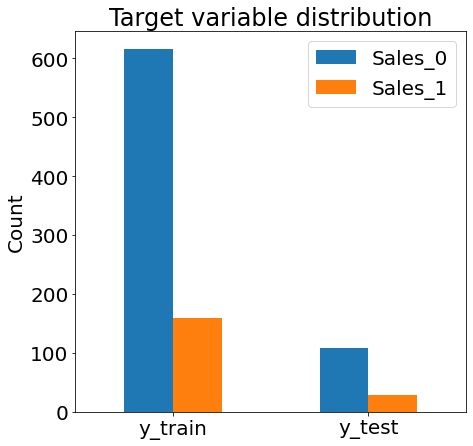

In [187]:
# Visualize target data distribution
plotdata=pd.DataFrame({
    "Sales_0":[y_train.value_counts()[0],y_test.value_counts()[0]],
    "Sales_1":[y_train.value_counts()[1],y_test.value_counts()[1]]},
     index=["y_train","y_test"])
plotdata.plot(kind="bar",figsize=(7,7))
plt.xticks(rotation="horizontal")
plt.title("Target variable distribution")
plt.rcParams.update({'font.size': 15})
plt.ylabel("Count")

Note that the data available for Sales_1 field is far lesser than the data available for Sales_0 field. This could contribute to poor model performance. There are many ways to handle imbalance in datasets: namely Undersampling, Oversampling, Generation of synthetic data using SMOTE. Among all these methods, undersampling is not applicable for this problem, because we already have insufficient data to start with. Hence, random oversampling is used to handle the problem of imbalanced data in this case.

In [188]:
# Using oversampling to handle the imbalance in proportion of samples belonging to Sales_0 and Sales_1
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_revenue,y)

In [189]:
# Splitting data into training and test sets
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over,y_over,test_size=0.15, random_state=0,stratify=y_over) 

Text(0, 0.5, 'Count')

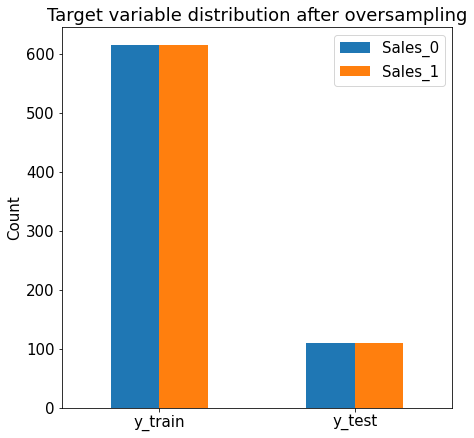

In [190]:
# Visualize target data distribution for over-sampled data
plotdata=pd.DataFrame({
    "Sales_0":[y_train_over.value_counts()[0],y_test_over.value_counts()[0]],
    "Sales_1":[y_train_over.value_counts()[1],y_test_over.value_counts()[1]]},
     index=["y_train","y_test"])
plotdata.plot(kind="bar",figsize=(7,7))
plt.xticks(rotation="horizontal")
plt.title("Target variable distribution after oversampling")
plt.rcParams.update({'font.size': 20})
plt.ylabel("Count")

Now train the XGBoost model to see if there is any improvement in model performance

### Training an XGBoost classifier with the balanced data

In [191]:
# define the model and fit to training data
model_over=XGBClassifier()
model_over=model_over.fit(X_train_over.loc[:,X_train_over.columns!='Revenue_MF'],y_train_over)

# Calculate weights of each feature
importance=model_over.feature_importances_

#summarize feature importance
df=pd.DataFrame({'Feature':X.columns,'Importance':importance})
df.set_index('Feature',inplace=True)
df.sort_values(by='Importance',ascending=False,inplace=True)

#get predictions from the model
y_pred_over=model_over.predict(X_test_over.loc[:,X_test_over.columns!='Revenue_MF'])

# Probability of predictions
pred_prob_over=model_over.predict_proba(X_test_over.loc[:,X_test_over.columns!='Revenue_MF'])[:,1]  # probability for class value 1

target_names=['Sales_MF']
print(classification_report(y_test_over,y_pred_over))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       109
           1       0.89      0.96      0.93       109

    accuracy                           0.92       218
   macro avg       0.92      0.92      0.92       218
weighted avg       0.92      0.92      0.92       218



There does seem to be an improvement in evaluation metrics, especially for class 1. Now get propensity and revenue scores from the model

In [192]:
clients=X_test_over.loc[:,'Client']
propensity=pred_prob_over
Propensity_MF_over=pd.DataFrame({"Client":clients,"Propensity":propensity})

Propensity_MF_over.drop_duplicates(subset=['Client'],inplace=True)
Propensity_MF_over['Propensity'].shape
clients=Propensity_MF_over['Client']

revenue = X_test_over.query('Client in @clients')['Revenue_MF']
revenue_adjusted = revenue.multiply(Propensity_MF_over['Propensity'])

# Add expected revenue field by multiplying revenue and propensity to buy the corresponding product
Propensity_MF_over['Revenue'] = revenue
Propensity_MF_over['Revenue_adjusted'] = revenue_adjusted
Propensity_MF_over['Product'] = 'MF'
Propensity_MF_over.sort_values("Propensity",ascending=False, inplace=True)
Propensity_MF_over

,Client,Propensity,Revenue,Revenue_adjusted,Product
1070,187,0.998754,2.701071,2.697707,MF
617,1091,0.998425,4.910714,4.902982,MF
1255,1135,0.996945,6.136429,6.117679,MF
1208,1399,0.996258,27.233750,27.131848,MF
464,826,0.995293,0.000000,0.000000,MF
...,...,...,...,...,...
49,83,0.001331,0.000000,0.000000,MF
762,1345,0.001230,0.000000,0.000000,MF
29,49,0.000993,0.000000,0.000000,MF
869,1545,0.000953,0.000000,0.000000,MF


In [193]:
# This code line returns feature importance calculated by XGBoost classifier, 
# can be used for comparing with the feature importance scores returned by Decision tree classifier

#print("Feature importance calculated by XGBoost: {0}\n".format(df))

## Model for customer propensity to buy credit card

In [194]:
# Using normalized data

X=data_norm.iloc[:,:33] 
y=data_norm.iloc[:,34:35] 
revenue_CC = data_norm.loc[:,'Revenue_CC']
X_revenue=pd.concat([X,revenue_CC],axis=1)

In [195]:
# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=0,stratify=y) 

In [196]:
X_train.shape

(774, 33)

In [197]:
X_test.shape

(137, 33)

In [198]:
X_test.head()

,Client,Age,Tenure,Sex_F,Sex_M,Sex_Other,Tenure_years,Count_CA,Count_SA,Count_MF,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
312,564,0.623529,0.118081,0.0,1.0,0.0,0.118081,0.000000,0.000000,0.000000,...,0.002115,0.002129,0.000000,0.000000,0.002167,0.029412,0.036145,0.00,0.000000,0.058824
341,610,0.282353,0.782288,0.0,1.0,0.0,0.782288,0.000000,0.333333,0.012658,...,0.134268,0.134659,0.005758,0.008915,0.019858,0.166667,0.180723,0.08,0.016667,0.235294
507,904,0.211765,0.560886,1.0,0.0,0.0,0.560886,0.000000,0.000000,0.000000,...,0.010132,0.010200,0.010000,0.083284,0.001836,0.137255,0.168675,0.04,0.150000,0.088235
809,1428,0.529412,0.557196,1.0,0.0,0.0,0.557196,0.000000,0.000000,0.000000,...,0.000014,0.000014,0.000000,0.000000,0.000000,0.058824,0.012048,0.00,0.000000,0.000000
268,486,0.447059,0.719557,0.0,1.0,0.0,0.719557,0.333333,0.000000,0.000000,...,0.000086,0.000086,0.000000,0.000000,0.000000,0.009804,0.012048,0.00,0.000000,0.000000


### Training an XGBoost Classifier

In [199]:
# define the model and fit to training data
#weights={0:1.0,1:10.0}
model = XGBClassifier()
model = model.fit(X_train,y_train)

#get predictions from the model
y_pred_gini=model.predict(X_test)
target_names=['Sales_CC']
print(classification_report(y_test,y_pred_gini))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       103
           1       0.27      0.18      0.21        34

    accuracy                           0.68       137
   macro avg       0.51      0.51      0.51       137
weighted avg       0.64      0.68      0.65       137



In [200]:
# Predict propensity 
pred_prob=model.predict_proba(X_test)[:,1]
pred_prob

array([0.03373151, 0.35682124, 0.28707442, 0.8950646 , 0.90818846,
       0.05193117, 0.00146274, 0.17186278, 0.2586542 , 0.03833523,
       0.00714374, 0.00206569, 0.16031754, 0.01742029, 0.76244766,
       0.42227387, 0.00339445, 0.38008437, 0.00542048, 0.00856963,
       0.1099613 , 0.1501475 , 0.00906888, 0.07634279, 0.20746626,
       0.61007446, 0.00510656, 0.01942616, 0.00396563, 0.961617  ,
       0.01945639, 0.1272102 , 0.01188885, 0.01138123, 0.25667396,
       0.03158513, 0.11333507, 0.03941499, 0.05328519, 0.66222125,
       0.11290286, 0.0533953 , 0.0497792 , 0.02355113, 0.58913904,
       0.01059709, 0.97190374, 0.00782717, 0.01438773, 0.00329623,
       0.9971629 , 0.09194167, 0.38558492, 0.04564128, 0.04127672,
       0.06663679, 0.4379634 , 0.0124228 , 0.0122545 , 0.6151366 ,
       0.20777944, 0.00247306, 0.1117898 , 0.00884698, 0.02097807,
       0.01785042, 0.50358635, 0.0054053 , 0.03172144, 0.9984383 ,
       0.05657148, 0.14574467, 0.31966347, 0.09169346, 0.95693

In [202]:
clients=X_test.loc[:,'Client']
revenue=data.query('Client in @clients')['Revenue_CC']
propensity=pred_prob
revenue_adjusted=revenue.multiply(propensity)

Propensity_CC=pd.DataFrame({"Client":clients, "Revenue":revenue,"Propensity":propensity})
Propensity_CC['Revenue adjusted'] = revenue_adjusted
Propensity_CC.sort_values("Propensity",ascending=False,inplace=True)
Propensity_CC

,Client,Revenue,Propensity,Revenue adjusted
431,767,0.000000,0.998438,0.000000
276,499,0.000000,0.997163,0.000000
253,461,0.000000,0.971904,0.000000
151,275,6.428571,0.961617,6.181824
470,840,3.510714,0.956939,3.359540
...,...,...,...,...
268,486,0.000000,0.003296,0.000000
726,1290,0.000000,0.002638,0.000000
385,691,0.000000,0.002473,0.000000
57,95,0.000000,0.002066,0.000000


### Feature selection using Decision tree

The goal is to use decision tree classifier to reduce dimensions of the data (feature selection), after which the machine learning model should be able to perform the same as before, or better.

In [203]:
#define the model
model=DecisionTreeClassifier() # default split criterion: gini 
#fit the model with X,y data
model.fit(X,y)
#get feature importance
importance=model.feature_importances_
#summarize feature importance
df=pd.DataFrame({'Feature':X.columns,'Importance':importance})
df.set_index('Feature',inplace=True)
df.sort_values(by='Importance',ascending=False,inplace=True)
df

,Importance
Feature,
ActBal_CA,0.168420
VolumeDeb_PaymentOrder,0.124470
ActBal_SA,0.078971
Tenure,0.064475
TransactionsDeb_PaymentOrder,0.060700
Client,0.058164
VolumeDeb,0.058016
Tenure_years,0.043381
VolumeCred,0.040209


In [204]:
# Include features with importance scores > 0.01
cols_to_include=df[df['Importance']>0.01].index.tolist()

In [205]:
# Train XGBoost classifier with the reduced data
# define the model and fit to training data
#weights={0:1.0,1:10.0}

model= XGBClassifier()
model=model.fit(X_train.loc[:,cols_to_include],y_train)

#get predictions from the model
y_pred=model.predict(X_test.loc[:,cols_to_include])
target_names=['Sales_CC']
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       103
           1       0.30      0.18      0.22        34

    accuracy                           0.69       137
   macro avg       0.53      0.52      0.52       137
weighted avg       0.65      0.69      0.66       137



Comparing precision, recall and F1 scores before and after feature selection, it is evident that with reduced set of features, the model performance does not have a major impact, i.e; neither a major improvement nor a deterioration in performance can be noted.

### Handling imbalanced data 

Visualize the distribution of target variable (Sales) in class values 0 and 1. Often times, a mismatch in target data distribution hampers the learning capacity of the machine learning model.

Text(0, 0.5, 'Count')

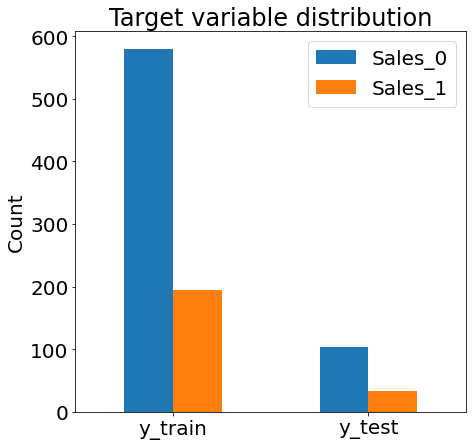

In [206]:
# Visualize target data distribution
plotdata=pd.DataFrame({
    "Sales_0":[y_train.value_counts()[0],y_test.value_counts()[0]],
    "Sales_1":[y_train.value_counts()[1],y_test.value_counts()[1]]},
     index=["y_train","y_test"])
plotdata.plot(kind="bar",figsize=(7,7))
plt.xticks(rotation="horizontal")
plt.title("Target variable distribution")
plt.ylabel("Count")

Note that the data available for Sales_1 field is far lesser than the data available for Sales_0 field. This could contribute to poor model performance. There are many ways to handle imbalance in datasets: namely Undersampling, Oversampling, Generation of synthetic data using SMOTE. Among all these methods, undersampling is not applicable for this problem, because we already have insufficient data to start with. Hence, random oversampling is used to handle the problem of imbalanced data in this case.

In [207]:
# Using oversampling to handle the imbalance in proportion of samples belonging to Sales_0 and Sales_1
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_revenue,y)

In [208]:
# Splitting data into training and test sets
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over,y_over,test_size=0.15, random_state=0,stratify=y_over) 

Text(0, 0.5, 'Count')

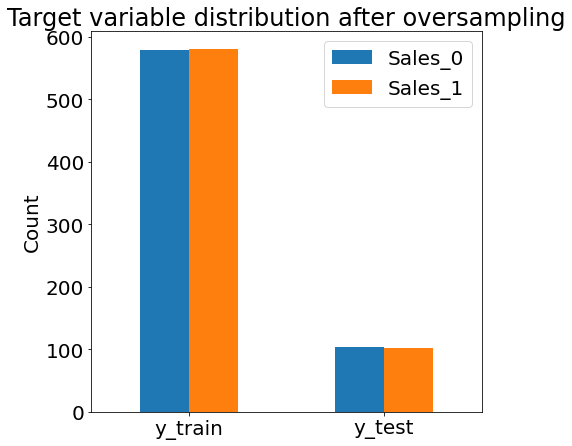

In [209]:
# Visualize target data distribution for over-sampled data
plotdata=pd.DataFrame({
    "Sales_0":[y_train_over.value_counts()[0],y_test_over.value_counts()[0]],
    "Sales_1":[y_train_over.value_counts()[1],y_test_over.value_counts()[1]]},
     index=["y_train","y_test"])
plotdata.plot(kind="bar",figsize=(7,7))
plt.xticks(rotation="horizontal")
plt.title("Target variable distribution after oversampling")
plt.ylabel("Count")

Now train the XGBoost model to see if there is any improvement in model performance

### Training an XGBoost classifier with the balanced data

In [210]:
# define the model and fit to training data
#weights={0:1.0,1:10.0}
model_over=XGBClassifier()
model_over=model_over.fit(X_train_over.loc[:,X_train_over.columns!='Revenue_CC'],y_train_over)

# Calculate weights of each feature
importance=model_over.feature_importances_

#summarize feature importance
df=pd.DataFrame({'Feature':X.columns,'Importance':importance})
df.set_index('Feature',inplace=True)
df.sort_values(by='Importance',ascending=False,inplace=True)

#get predictions from the model
y_pred_over=model_over.predict(X_test_over.loc[:,X_test_over.columns!='Revenue_CC'])

# Probability of predictions
pred_prob_over=model_over.predict_proba(X_test_over.loc[:,X_test_over.columns!='Revenue_CC'])[:,1]  # probability for class value 1

target_names=['Sales_CC']
print(classification_report(y_test_over,y_pred_over))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84       103
           1       0.80      0.95      0.87       102

    accuracy                           0.85       205
   macro avg       0.87      0.85      0.85       205
weighted avg       0.87      0.85      0.85       205



There does seem to be an improvement in evaluation metrics, especially for class 1. Now get propensity and revenue scores from the model

In [211]:
clients=X_test_over.loc[:,'Client']
propensity=pred_prob_over
Propensity_CC_over=pd.DataFrame({"Client":clients,"Propensity":propensity})

Propensity_CC_over.drop_duplicates(subset=['Client'],inplace=True)
Propensity_CC_over['Propensity'].shape
clients=Propensity_CC_over['Client']

revenue=X_test_over.query('Client in @clients')['Revenue_CC']
revenue_adjusted=revenue.multiply(Propensity_CC_over['Propensity'])

# Add adjusted revenue field by multiplying revenue and propensity to buy the corresponding product
Propensity_CC_over['Revenue'] = revenue
Propensity_CC_over['Revenue_adjusted'] = revenue_adjusted
Propensity_CC_over['Product'] = 'CC'
Propensity_CC_over.sort_values("Propensity",ascending=False, inplace=True)
Propensity_CC_over

,Client,Propensity,Revenue,Revenue_adjusted,Product
1286,420,0.998275,6.785714,6.774010,CC
1099,908,0.997988,26.998214,26.943890,CC
803,1413,0.997144,6.964286,6.944398,CC
1342,1549,0.996297,2.679286,2.669363,CC
1320,694,0.995698,5.572500,5.548528,CC
...,...,...,...,...,...
80,139,0.006238,0.000000,0.000000,CC
746,1318,0.003846,0.000000,0.000000,CC
42,75,0.003088,0.000000,0.000000,CC
371,662,0.001653,0.000000,0.000000,CC


In [212]:
# This code line returns feature importance calculated by XGBoost classifier, 
# can be used for comparing with the feature importance scores returned by Decision tree classifier

#print("Feature importance calculated by XGBoost: {0}\n".format(df))

## Model for customer propensity to buy consumer loan

In [213]:
# Using normalized data
X=data.iloc[:,:33] 
y=data.iloc[:,35:36] 
revenue_CL = data.iloc[:,38]
X_revenue=pd.concat([X,revenue_CL],axis=1)

In [214]:
# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=0,stratify=y) 

### Training an XGBoost Classifier

In [215]:
# define the model and fit to training data
#weights={0:1.0,1:10.0}
model = XGBClassifier()
model = model.fit(X_train,y_train)

#get predictions from the model
y_pred=model.predict(X_test)
target_names=['Sales_CL']
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79        97
           1       0.42      0.25      0.31        40

    accuracy                           0.68       137
   macro avg       0.58      0.55      0.55       137
weighted avg       0.64      0.68      0.65       137



In [216]:
# Predict propensity 
pred_prob=model.predict_proba(X_test)[:,1]
pred_prob

array([7.06547737e-01, 9.07576922e-03, 4.08920553e-03, 3.84696312e-02,
       5.64804494e-01, 6.99503124e-02, 7.44709326e-03, 1.49362562e-02,
       1.95055515e-01, 9.57303226e-01, 6.04420364e-01, 5.29142246e-02,
       2.27176577e-01, 5.74235559e-01, 8.79140384e-03, 5.41049480e-01,
       1.30150625e-02, 7.43624195e-03, 8.16796124e-01, 2.17592940e-01,
       9.06771645e-02, 3.67976987e-04, 2.37174287e-01, 8.06218162e-02,
       1.08242057e-01, 4.00742352e-01, 3.17707151e-01, 7.94291496e-01,
       2.43889198e-01, 9.90385652e-01, 5.49735069e-01, 6.23463392e-02,
       9.55236796e-03, 3.02621871e-01, 1.19467760e-02, 8.04065391e-02,
       3.10069382e-01, 9.07632485e-02, 1.42261107e-02, 3.73943120e-01,
       2.20478654e-01, 4.51024741e-01, 2.52196968e-01, 4.04555397e-03,
       5.01743183e-02, 8.22269451e-03, 9.79049876e-03, 1.61325857e-01,
       1.34055391e-02, 3.41280736e-02, 7.15194643e-01, 1.29858637e-02,
       7.74513006e-01, 1.75453693e-01, 3.25844996e-02, 2.64647249e-02,
      

In [217]:
clients=X_test.loc[:,'Client']
revenue=data.query('Client in @clients')['Revenue_CL']
propensity=pred_prob
revenue_adjusted=revenue.multiply(propensity)

Propensity_CL=pd.DataFrame({"Client":clients, "Revenue":revenue,"Propensity":propensity})
Propensity_CL.sort_values("Propensity",ascending=False,inplace=True)

# Add adjusted revenue field by multiplying revenue and propensity to buy the corresponding product
Propensity_CL['Revenue_adjusted'] = revenue_adjusted
Propensity_CL.sort_values("Propensity",ascending=False, inplace=True)
Propensity_CL

,Client,Revenue,Propensity,Revenue_adjusted
172,306,0.000000,0.990386,0.000000
55,92,0.000000,0.957303,0.000000
770,1355,5.857143,0.915992,5.365095
412,737,0.000000,0.845565,0.000000
645,1152,0.000000,0.834827,0.000000
...,...,...,...,...
559,992,0.000000,0.003057,0.000000
441,789,0.000000,0.003019,0.000000
605,1066,0.000000,0.001551,0.000000
583,1030,8.428571,0.000758,0.006387


### Feature selection using Decision tree

The goal is to use decision tree classifier to reduce dimensions of the data (feature selection), after which the machine learning model should be able to perform the same as before, or better.

In [218]:
#define the model
model=DecisionTreeClassifier() # default split criterion: gini 
#fit the model with X,y data
model.fit(X,y)
#get feature importance
importance=model.feature_importances_
#summarize feature importance
df=pd.DataFrame({'Feature':X.columns,'Importance':importance})
df.set_index('Feature',inplace=True)
df.sort_values(by='Importance',ascending=False,inplace=True)
df

,Importance
Feature,
ActBal_CA,0.112781
Tenure_years,0.091920
Age,0.072635
Tenure,0.061597
TransactionsDeb,0.052031
Client,0.048050
VolumeDeb,0.047625
VolumeDeb_PaymentOrder,0.046937
TransactionsCred,0.044741


In [219]:
# Include features with importance scores > 0.01
cols_to_include=df[df['Importance']>0.01].index.tolist()

### Training XGBoost Classifier with selected features

In [220]:
# Train XGBoost classifier with the reduced data
# define the model and fit to training data
#weights={0:1.0,1:10.0}

model= XGBClassifier()
model=model.fit(X_train.loc[:,cols_to_include],y_train)

#get predictions from the model
y_pred=model.predict(X_test.loc[:,cols_to_include])
target_names=['Sales_CL']
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.84      0.76        97
           1       0.27      0.15      0.19        40

    accuracy                           0.64       137
   macro avg       0.49      0.49      0.48       137
weighted avg       0.58      0.64      0.60       137



Comparing precision, recall and F1 scores before and after feature selection, it is evident that with reduced set of features, the model performance does not have a major impact, i.e; neither a major improvement nor a deterioration in performance can be noted.

### Handling imbalanced data 

Visualize the distribution of target variable (Sales) in class values 0 and 1. Often times, a mismatch in target data distribution hampers the learning capacity of the machine learning model.

Text(0, 0.5, 'Count')

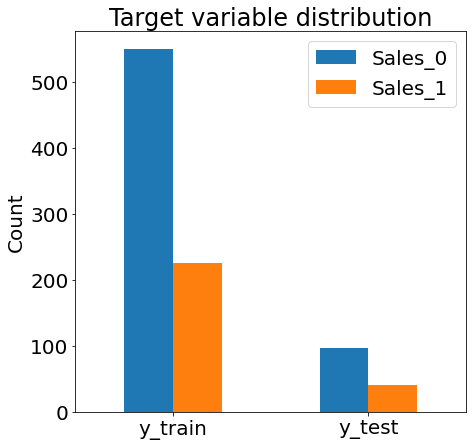

In [221]:
# Visualize target data distribution
plotdata=pd.DataFrame({
    "Sales_0":[y_train.value_counts()[0],y_test.value_counts()[0]],
    "Sales_1":[y_train.value_counts()[1],y_test.value_counts()[1]]},
     index=["y_train","y_test"])
plotdata.plot(kind="bar",figsize=(7,7))
plt.xticks(rotation="horizontal")
plt.title("Target variable distribution")
plt.ylabel("Count")

Note that the data available for Sales_1 field is far lesser than the data available for Sales_0 field. This could contribute to poor model performance. There are many ways to handle imbalance in datasets: namely Undersampling, Oversampling, Generation of synthetic data using SMOTE. Among all these methods, undersampling is not applicable for this problem, because we already have insufficient data to start with. Hence, random oversampling is used to handle the problem of imbalanced data in this case.

In [222]:
# Using oversampling to handle the imbalance in proportion of samples belonging to Sales_0 and Sales_1
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_revenue,y)

In [223]:
# Splitting data into training and test sets
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over,y_over,test_size=0.15, random_state=0,stratify=y_over) 

Text(0, 0.5, 'Count')

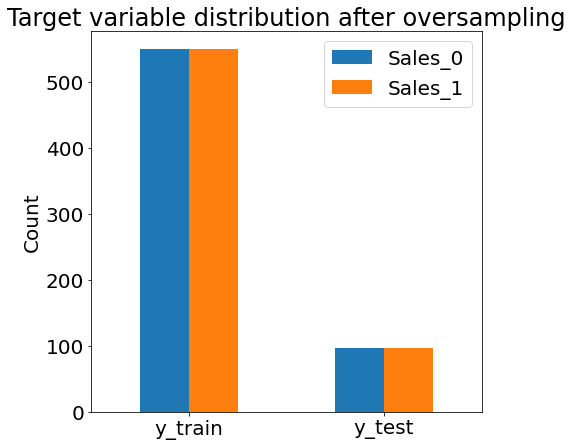

In [224]:
# Visualize target data distribution for over-sampled data
plotdata=pd.DataFrame({
    "Sales_0":[y_train_over.value_counts()[0],y_test_over.value_counts()[0]],
    "Sales_1":[y_train_over.value_counts()[1],y_test_over.value_counts()[1]]},
     index=["y_train","y_test"])
plotdata.plot(kind="bar",figsize=(7,7))
plt.xticks(rotation="horizontal")
plt.title("Target variable distribution after oversampling")
plt.ylabel("Count")

Now train the XGBoost classifier with the oversampled data

### Training an XGBoost classifier with the balanced data

In [225]:
# define the model and fit to training data
#weights={0:1.0,1:10.0}
model_over= XGBClassifier()
model_over=model_over.fit(X_train_over.loc[:,X_train_over.columns!='Revenue_CL'],y_train_over)

# Calculate weights of each feature
importance=model_over.feature_importances_

#summarize feature importance
df=pd.DataFrame({'Feature':X.columns,'Importance':importance})
df.set_index('Feature',inplace=True)
df.sort_values(by='Importance',ascending=False,inplace=True)


#get predictions from the model
y_pred_over=model_over.predict(X_test_over.loc[:,X_test_over.columns!='Revenue_CL'])

# Probability of predictions
pred_prob_over=model_over.predict_proba(X_test_over.loc[:,X_test_over.columns!='Revenue_CL'])[:,1]  # probability for class value 1

target_names=['Sales_CL']
print(classification_report(y_test_over,y_pred_over))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83        97
           1       0.82      0.88      0.85        97

    accuracy                           0.84       194
   macro avg       0.84      0.84      0.84       194
weighted avg       0.84      0.84      0.84       194



In [226]:
clients=X_test_over.loc[:,'Client']
propensity=pred_prob_over
Propensity_CL_over=pd.DataFrame({"Client":clients,"Propensity":propensity})

Propensity_CL_over.drop_duplicates(subset=['Client'],inplace=True)
Propensity_CL_over['Propensity'].shape
clients=Propensity_CL_over['Client']

revenue=X_test_over.query('Client in @clients')['Revenue_CL']
revenue_adjusted=revenue.multiply(Propensity_CL_over['Propensity'])

# Add adjusted revenue field by multiplying revenue and propensity to buy the corresponding product
Propensity_CL_over['Revenue'] = revenue
Propensity_CL_over['Revenue_adjusted'] = revenue_adjusted
Propensity_CL_over.sort_values("Propensity",ascending=False, inplace=True)
Propensity_CL_over['Product'] = 'MF'
Propensity_CL_over

,Client,Propensity,Revenue,Revenue_adjusted,Product
1237,298,0.997935,22.966429,22.919004,MF
752,1329,0.997527,7.964286,7.944589,MF
1214,495,0.995871,4.488214,4.469683,MF
969,584,0.994746,8.750000,8.704025,MF
994,630,0.993407,16.925000,16.813412,MF
...,...,...,...,...,...
150,272,0.005521,13.469643,0.074361,MF
795,1400,0.004200,0.000000,0.000000,MF
51,86,0.002180,0.000000,0.000000,MF
1042,1391,0.001813,4.250000,0.007706,MF


In [227]:
# This code line returns feature importance calculated by XGBoost classifier, 
# can be used for comparing with the feature importance scores returned by Decision tree classifier

#print("Feature importance calculated by XGBoost: {0}\n".format(df))

In [90]:
# Write results to excel sheet
with pd.ExcelWriter('D:/Courses and Projects/Revenue optimization/Binary classification/XGBoost/Customer propensity.xlsx') as writer:
        Propensity_MF.to_excel(writer,sheet_name='MutualFunds',index=False)
        Propensity_CC.to_excel(writer,sheet_name='CreditCard',index=False)
        Propensity_CL.to_excel(writer,sheet_name='ConsumerLoan',index=False)

In [92]:
# Write results to excel sheet
with pd.ExcelWriter('D:/Courses and Projects/Revenue optimization/Binary classification/XGBoost/Customer propensity_OverSampled.xlsx') as writer:
        Propensity_MF_over.to_excel(writer,sheet_name='MutualFunds',index=False)
        Propensity_CC_over.to_excel(writer,sheet_name='CreditCard',index=False)
        Propensity_CL_over.to_excel(writer,sheet_name='ConsumerLoan',index=False)